### Данный ноутбук был написан чтобы обучить модель сегментации (Unet) для выделения сегмента в детектировоном участке фото, для дальнейшего выравнивания номерного знака автомобиля - This notebook was written to train a segmentation model (Unet) to select a segment in the detected area of the photo, for further alignment of the car license plate

# Importing libraries - Импорт библиотек

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=05874cda7d721ab5191d0c6caf11ea0cae7b07c6da58c011c2f211c06989eeda
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=80680985b63423fb25e988c259576418d293f902e2f9ac4b7c4a51b8dd2811dc
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [2]:
!pip install --upgrade tqdm

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage.transform import resize
import segmentation_models_pytorch as smp

import json
from glob import glob
import os
import cv2

from tqdm import tqdm_notebook
import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# We write functions and classes for preprocessing and training the model - Прописываем функции и классы для предобработки и обучения модели

In [4]:
def creatDataFrame(data: list, path: str) -> pd.DataFrame:
    data_columns = {
    'fileName': [],
    'rle_mask': [],
    'class': []
    }

    for elem in tqdm_notebook(data['annotations']):
        img = [i['file_name'] for i in data['images'] if i['id'] == elem['image_id']][0]
        img = [path + "/" + i['file_name'] for i in data['images'] if i['id'] == elem['image_id']][0]
        data_columns['fileName'].append(img)
        data_columns['rle_mask'].append(' '.join(map(lambda x: str(int(round(x))), elem['segmentation'][0])))
        data_columns['class'].append(elem['category_id'])
    return pd.DataFrame(data_columns)

In [5]:
def rle_decode(coordinates: str, image_shape=(640, 640)) -> np.ndarray:
    points = []
    dt = coordinates.split()
    for i in range(0, len(dt), 2):
        points.append((int(dt[i]), int(dt[i + 1])))
    mask = np.zeros(image_shape, dtype=np.uint8)
    for coord in points:
        mask[coord[1] - 1, coord[0] - 1] = 1
    for i in range(len(points) - 1):
        cv2.line(mask, points[i], points[i + 1], (1, 1, 1), 1)
    cv2.fillPoly(mask, [np.array(points)], (1, 1, 1))
    return mask

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        mask_rle = self.dataframe.iloc[idx, 1]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found.")
        image = Image.open(img_path).convert('RGB')
        mask = rle_decode(mask_rle, (image.height, image.width))
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask

In [7]:
class Metrics:
    @staticmethod
    def f1_score(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        return f1.item()

    @staticmethod
    def precision(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        return precision.item()

    @staticmethod
    def recall(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        recall = tp / (tp + fn + 1e-6)
        return recall.item()

    @staticmethod
    def accuracy(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        correct = (y_true == y_pred).float().sum()
        accuracy = correct / y_true.numel()
        return accuracy.item()

# Data analysis - Анализ данных

In [8]:
with open('/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_1 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train')

with open('/kaggle/input/car-number-segment/misha_segm/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_2 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/misha_segm/train')
    
with open('/kaggle/input/car-number-segment/sasha/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_3 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/sasha/train')

with open('/kaggle/input/car-number-segment/simon/train/_annotations.coco.json', 'r', encoding='utf-8') as data:
    data_4 = creatDataFrame(json.load(data), path='/kaggle/input/car-number-segment/simon/train')

/tmp/ipykernel_24/196596626.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for elem in tqdm_notebook(data['annotations']):


  0%|          | 0/568 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

In [9]:
data_1

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/car_numbers.v...,8 49 158 40 158 10 6 18 8 49,1
1,/kaggle/input/car-number-segment/car_numbers.v...,8 52 224 52 226 11 8 11 8 52,1
2,/kaggle/input/car-number-segment/car_numbers.v...,12 139 287 79 282 11 4 74 12 139,1
3,/kaggle/input/car-number-segment/car_numbers.v...,6 57 222 111 226 63 11 7 6 57,1
4,/kaggle/input/car-number-segment/car_numbers.v...,106 13 16 8 10 27 102 34 106 13,1
...,...,...,...
563,/kaggle/input/car-number-segment/car_numbers.v...,13 65 309 62 310 7 12 11 13 65,1
564,/kaggle/input/car-number-segment/car_numbers.v...,194 7 11 36 5 96 189 62 194 7,1
565,/kaggle/input/car-number-segment/car_numbers.v...,94 7 5 24 5 46 95 28 94 7,1
566,/kaggle/input/car-number-segment/car_numbers.v...,177 14 7 6 5 38 174 45 177 14,1


In [10]:
data_2

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/misha_segm/tr...,309 8 16 7 12 64 305 65 309 8,1
1,/kaggle/input/car-number-segment/misha_segm/tr...,10 45 137 46 135 11 8 5 10 45,1
2,/kaggle/input/car-number-segment/misha_segm/tr...,10 33 99 28 99 8 9 13 10 33,1
3,/kaggle/input/car-number-segment/misha_segm/tr...,7 72 255 62 258 6 7 17 7 72,1
4,/kaggle/input/car-number-segment/misha_segm/tr...,6 53 236 76 235 35 8 7 6 53,1
...,...,...,...
571,/kaggle/input/car-number-segment/misha_segm/tr...,10 37 143 33 142 8 9 12 10 37,1
572,/kaggle/input/car-number-segment/misha_segm/tr...,8 32 71 26 71 6 8 10 8 32,1
573,/kaggle/input/car-number-segment/misha_segm/tr...,9 76 334 67 331 2 8 12 9 76,1
574,/kaggle/input/car-number-segment/misha_segm/tr...,7 172 303 72 304 6 19 114 7 172,1


In [11]:
data_3

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/sasha/train/7...,7 11 10 32 137 32 135 9 7 10 7 11,1
1,/kaggle/input/car-number-segment/sasha/train/8...,170 71 178 33 24 9 15 43 170 71,1
2,/kaggle/input/car-number-segment/sasha/train/2...,8 40 10 79 147 48 146 47 144 8 8 40,1
3,/kaggle/input/car-number-segment/sasha/train/0...,145 34 146 7 8 6 8 33 145 34,1
4,/kaggle/input/car-number-segment/sasha/train/3...,150 3 8 65 23 90 164 30 150 3,1
...,...,...,...
660,/kaggle/input/car-number-segment/sasha/train/3...,8 60 192 44 183 4 1 19 8 60,1
661,/kaggle/input/car-number-segment/sasha/train/1...,6 25 6 38 62 18 62 6 6 25 6 25,1
662,/kaggle/input/car-number-segment/sasha/train/9...,7 48 206 69 209 29 7 5 7 48,1
663,/kaggle/input/car-number-segment/sasha/train/5...,7 6 10 31 95 47 92 22 7 6,1


In [12]:
data_4

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/simon/train/b...,197 32 9 6 8 41 195 68 197 32,1
1,/kaggle/input/car-number-segment/simon/train/a...,5 24 83 34 87 14 8 7 5 24,1
2,/kaggle/input/car-number-segment/simon/train/4...,15 89 179 56 174 1 11 37 15 89,1
3,/kaggle/input/car-number-segment/simon/train/b...,7 37 154 43 158 13 10 9 7 37,1
4,/kaggle/input/car-number-segment/simon/train/7...,17 82 216 59 209 11 7 39 17 82,1
...,...,...,...
561,/kaggle/input/car-number-segment/simon/train/a...,9 26 67 20 64 3 5 12 9 26,1
562,/kaggle/input/car-number-segment/simon/train/b...,9 71 197 45 195 9 8 36 9 71,1
563,/kaggle/input/car-number-segment/simon/train/5...,6 59 260 69 262 19 10 5 6 59,1
564,/kaggle/input/car-number-segment/simon/train/5...,2 87 225 162 237 87 16 0 2 87,1


In [13]:
data_global = pd.concat([data_1, data_2, data_3, data_4])
data_global

,fileName,rle_mask,class
0,/kaggle/input/car-number-segment/car_numbers.v...,8 49 158 40 158 10 6 18 8 49,1
1,/kaggle/input/car-number-segment/car_numbers.v...,8 52 224 52 226 11 8 11 8 52,1
2,/kaggle/input/car-number-segment/car_numbers.v...,12 139 287 79 282 11 4 74 12 139,1
3,/kaggle/input/car-number-segment/car_numbers.v...,6 57 222 111 226 63 11 7 6 57,1
4,/kaggle/input/car-number-segment/car_numbers.v...,106 13 16 8 10 27 102 34 106 13,1
...,...,...,...
561,/kaggle/input/car-number-segment/simon/train/a...,9 26 67 20 64 3 5 12 9 26,1
562,/kaggle/input/car-number-segment/simon/train/b...,9 71 197 45 195 9 8 36 9 71,1
563,/kaggle/input/car-number-segment/simon/train/5...,6 59 260 69 262 19 10 5 6 59,1
564,/kaggle/input/car-number-segment/simon/train/5...,2 87 225 162 237 87 16 0 2 87,1


# Divide into training and validation set - Разделим на тренировочную и валидационную выборку

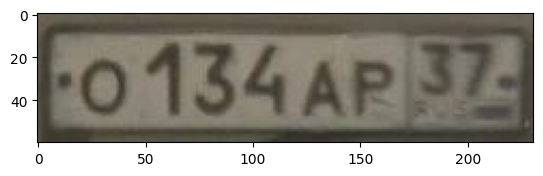

In [14]:
plt.imshow(cv2.imread(data_1.values[1][0]));

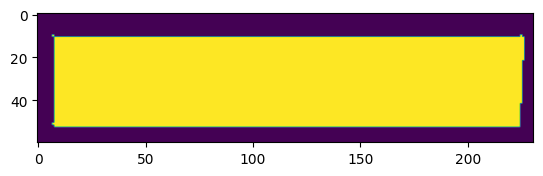

In [15]:
plt.imshow(rle_decode(coordinates=data_1.values[1][1], image_shape=cv2.imread(data_1.values[1][0]).shape[:2]));

In [16]:
image_transform = transforms.Compose([
    transforms.Resize((64, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda mask: resize(mask, (64, 192), order=0, preserve_range=True)),
    transforms.Lambda(lambda mask: torch.tensor(mask, dtype=torch.float32).unsqueeze(0))
])

In [17]:
train = data_global.iloc[380 + 200:, :]
valid = data_global.iloc[380:380 + 200, :]
test = data_global.iloc[:380]


train_dataset = SegmentationDataset(dataframe=train, transform=image_transform, mask_transform=mask_transform)
valid_dataset = SegmentationDataset(dataframe=valid, transform=image_transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(dataframe=test, transform=image_transform, mask_transform=mask_transform)

In [18]:
image, mask = train_dataset[0]
print(image.shape, mask.shape)

torch.Size([3, 64, 192]) torch.Size([1, 64, 192])


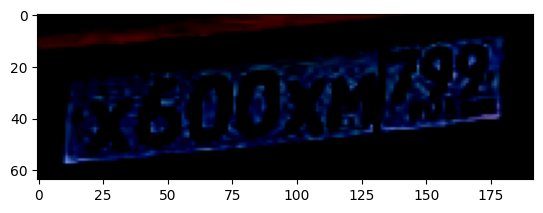

In [19]:
plt.imshow(image.permute(1, 2, 0).cpu().numpy());

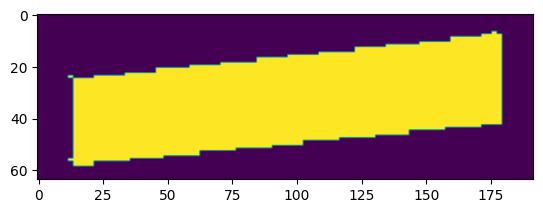

In [20]:
plt.imshow(mask.permute(1, 2, 0).cpu().numpy());

In [21]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


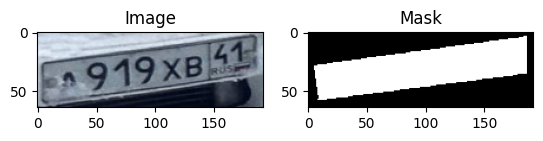

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


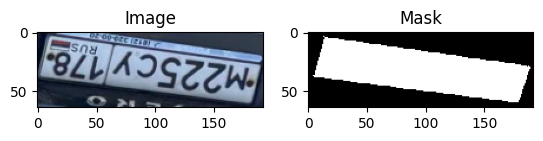

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


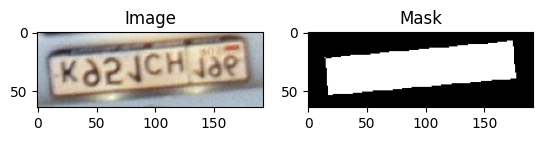

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


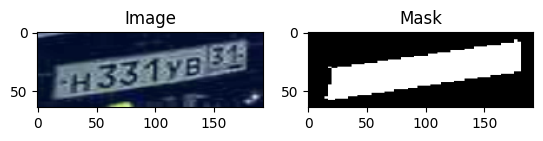

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


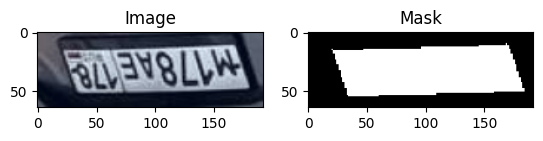

In [22]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

# Let’s initialize the model and write functions for training - С инициализируем модель и пропишим функции для обучения

In [23]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
loss_function = torch.nn.BCEWithLogitsLoss()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 309MB/s]


In [24]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function
    model.train()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        batch_size = x_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_sigmoid = torch.sigmoid(output)
        metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
        metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
        metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
        metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'Loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res


def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            output_sigmoid = torch.sigmoid(output)
            metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
            metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
            metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
            metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res

In [25]:
epoches = 16

train_losses = []
metric_res_train = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': []
}

valid_losses = []
metric_res_valid = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': []
}

best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0
}
best_model_wts = 'model'
min_loss = 10**9

for epoch in range(epoches):
    losses_train_epoch, metric_res_train_epoch = train_one_epoch(train_dataloader, epoch, Metrics)
    train_losses.append(losses_train_epoch)
    for i in metric_res_train_epoch:
        metric_res_train[i].append(metric_res_train_epoch[i])
    
    losses_val_epoch, metric_res_val_epoch = validation_one_epoch(valid_dataloader, Metrics)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])
    
    if any([best_metrics[i] < metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch
    
    scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


/tmp/ipykernel_24/3135605544.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.18801308120691676
f1_score: 0.935187947550856
precision: 0.9384608568919403
recall: 0.934265124831027
accuracy: 0.9335457575354403


/tmp/ipykernel_24/3135605544.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.10371989116072655
f1_score: 0.9651980996131897
precision: 0.9719690775871277
recall: 0.9588889002799987
accuracy: 0.963716652393341
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.1127009300385345
f1_score: 0.957373493328732
precision: 0.9578428310272089
recall: 0.9579496147904888
accuracy: 0.9561438401761493


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08916165553033352
f1_score: 0.9673100173473358
precision: 0.9739276111125946
recall: 0.9611489856243134
accuracy: 0.9658687543869019
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.09980317796671291
f1_score: 0.9606544270488877
precision: 0.9618353626522181
recall: 0.9601649862810098
accuracy: 0.9594538604648665


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08211522236466408
f1_score: 0.9694118773937226
precision: 0.9740451765060425
recall: 0.9650541925430298
accuracy: 0.9680151557922363
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.09262531613074969
f1_score: 0.9628792346021923
precision: 0.9642928784604192
recall: 0.9621111936555932
accuracy: 0.9617579422289283


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08212066069245338
f1_score: 0.9692987966537475
precision: 0.9722513365745544
recall: 0.9666823434829712
accuracy: 0.9678271663188934
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.08846068528369276
f1_score: 0.9641450659810334
precision: 0.9652089504146311
recall: 0.9636804094221598
accuracy: 0.9631148820800037


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08727472685277463
f1_score: 0.9649329376220703
precision: 0.9828001892566681
recall: 0.9480314838886261
accuracy: 0.9638395404815674
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.08403503197481373
f1_score: 0.9655601523048698
precision: 0.9670727583359211
recall: 0.9645627554744731
accuracy: 0.9645730166050053


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.07840659737586975
f1_score: 0.9691848468780517
precision: 0.9758798539638519
recall: 0.9629170429706574
accuracy: 0.9678894233703613
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.07977991334077043
f1_score: 0.967025758994323
precision: 0.9680339237441592
recall: 0.9664369749491594
accuracy: 0.9660108830271326


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08617354467511178
f1_score: 0.9641819226741791
precision: 0.9815295803546905
recall: 0.9477839636802673
accuracy: 0.9631042659282685
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.07664730142501071
f1_score: 0.9680570392223454
precision: 0.9693277740876987
recall: 0.967206481671931
accuracy: 0.9671440403773592


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08305688373744488
f1_score: 0.9674293708801269
precision: 0.9720325338840484
recall: 0.9632242298126221
accuracy: 0.9658211445808411
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.0731685730283639
f1_score: 0.9697174421924071
precision: 0.9704426017644345
recall: 0.9693601067351764
accuracy: 0.9688516652351634


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08808494471013546
f1_score: 0.9651235830783844
precision: 0.9749616479873657
recall: 0.9559272527694702
accuracy: 0.9635953950881958
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.06362294137353353
f1_score: 0.9735392075063126
precision: 0.9748981576111987
recall: 0.9724145747160845
accuracy: 0.9727819911616759


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08325794264674187
f1_score: 0.967834792137146
precision: 0.9715196073055268
recall: 0.9645696794986724
accuracy: 0.9662683260440826
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.05865282318178658
f1_score: 0.9754721560185998
precision: 0.9760528049429147
recall: 0.9750770362970889
accuracy: 0.9747654462591188


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.0848272705078125
f1_score: 0.9677501404285431
precision: 0.9709385848045349
recall: 0.9649780726432801
accuracy: 0.9662072944641114
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.056183280075658995
f1_score: 0.9765375559376475
precision: 0.9767565530986839
recall: 0.9764734079910852
accuracy: 0.9758478241378551


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08821705944836139
f1_score: 0.966736114025116
precision: 0.9750374066829681
recall: 0.9589488887786866
accuracy: 0.9652978718280792
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.05337814379452331
f1_score: 0.977793530966246
precision: 0.978909081602495
recall: 0.9768079406703747
accuracy: 0.9771804187623239


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08618540801107884
f1_score: 0.967760226726532
precision: 0.9696401214599609
recall: 0.9662743937969208
accuracy: 0.9661702680587768
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.05285015834033655
f1_score: 0.9780916858516364
precision: 0.9783498409398751
recall: 0.9779586203915163
accuracy: 0.9774498127297107


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08771132655441762
f1_score: 0.9671434032917022
precision: 0.9684048283100128
recall: 0.9662710762023926
accuracy: 0.9655135226249695
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.05265487663053536
f1_score: 0.9780212480709746
precision: 0.9786385870577565
recall: 0.9775294133215562
accuracy: 0.9774510830225719


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.0879101061820984
f1_score: 0.9671829092502594
precision: 0.9736450946331024
recall: 0.961173324584961
accuracy: 0.9657039618492127
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/449 [00:00<?, ?it/s]

Loss train: 0.0523878651409096
f1_score: 0.978164007205485
precision: 0.9782757074720017
recall: 0.9781659236193367
accuracy: 0.9775625210286515


  0%|          | 0/50 [00:00<?, ?it/s]

Loss validation: 0.08794978141784668
f1_score: 0.967341570854187
precision: 0.9715402841567993
recall: 0.9635562098026276
accuracy: 0.9658032405376434
-----------------------------------



# Learning outcomes - Результаты обучения

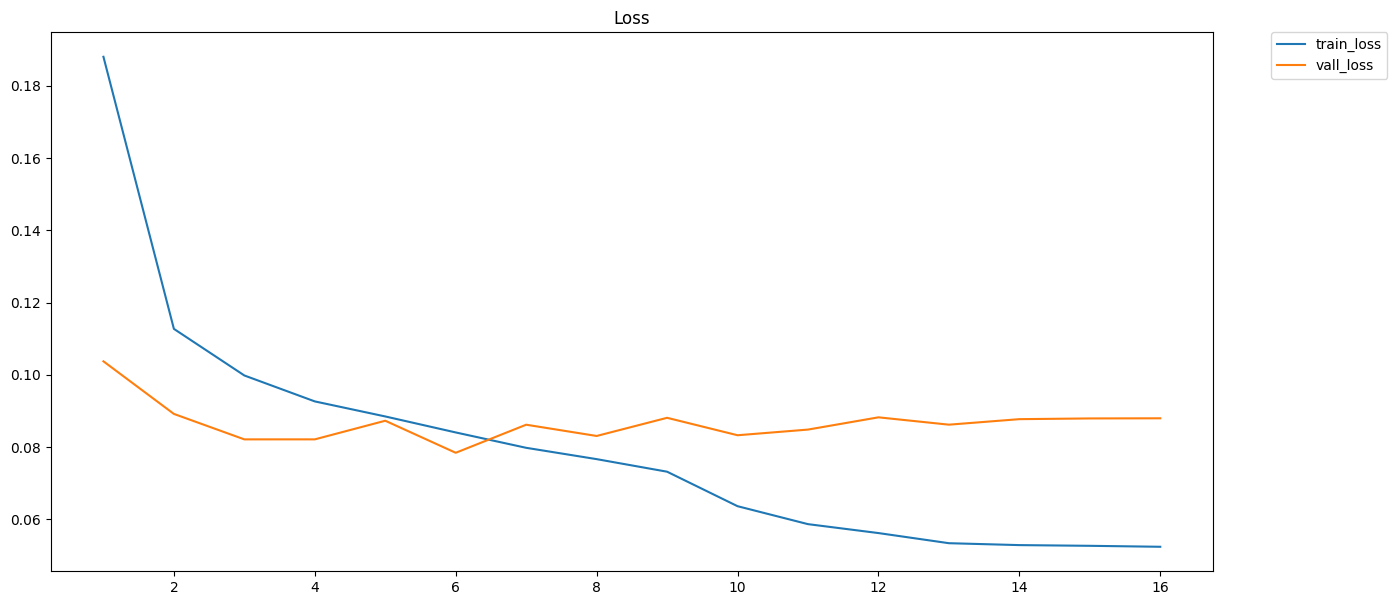

In [26]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

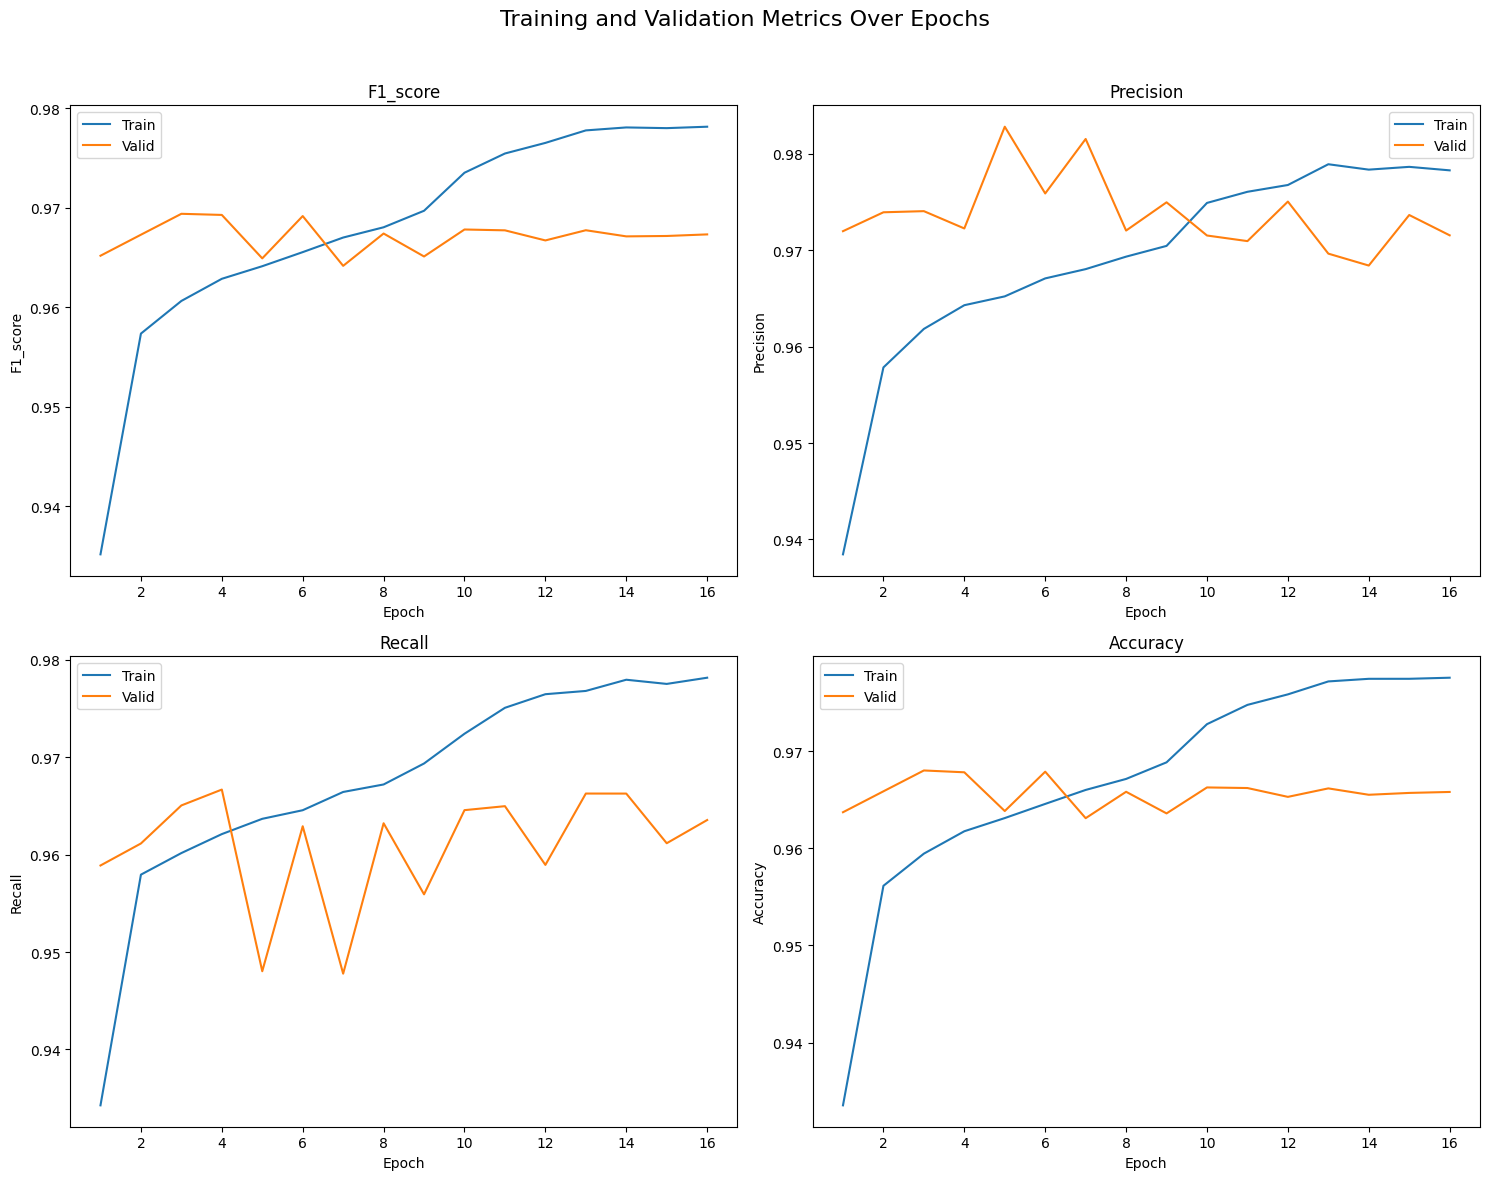

In [27]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')

best_metrics: {'f1_score': 0.9691848468780517, 'precision': 0.9758798539638519, 'recall': 0.9629170429706574, 'accuracy': 0.9678894233703613}
best_loss: 0.07840659737586975


# Visualizing the model's predictions - Визуализируем предсказания модели 

In [29]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


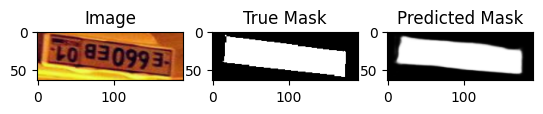

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


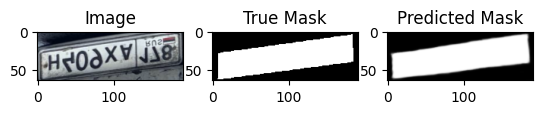

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


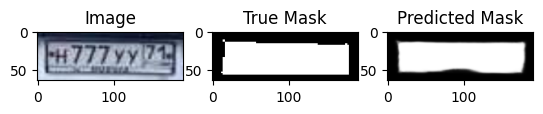

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


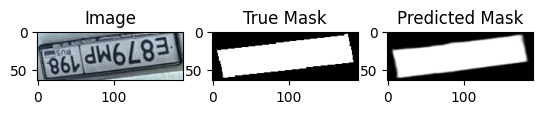

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


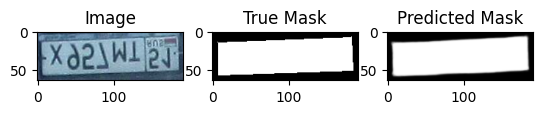

In [30]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    if batch_idx == 4:
        break

# Результаты на тесте

Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


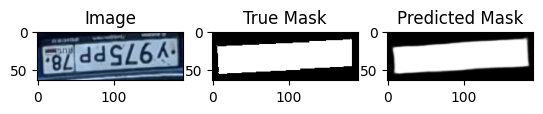

Batch 2
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


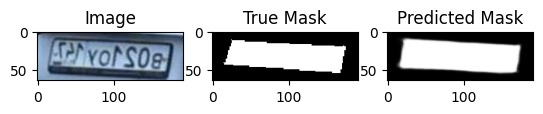

Batch 3
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


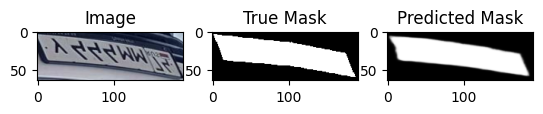

Batch 4
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


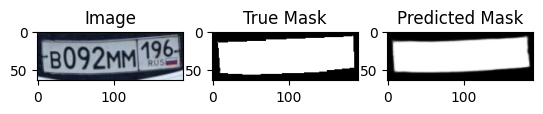

Batch 5
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


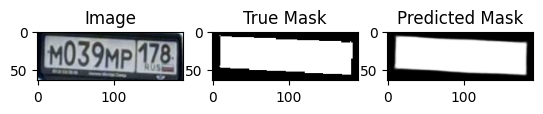

In [31]:
for batch_idx, (images, masks) in enumerate(test_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    if batch_idx == 4:
        break

In [32]:
result_metrics_test = validation_one_epoch(test_dataloader, Metrics)

/tmp/ipykernel_24/3135605544.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/95 [00:00<?, ?it/s]

Loss validation: 0.09191952065417641
f1_score: 0.9662204416174638
precision: 0.9699717477748269
recall: 0.962936070090846
accuracy: 0.9646431031980013
-----------------------------------



# Save model - Сохраняем модель 

In [33]:
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), 
    },
    'unet_model.pth'
)

In [34]:
torch.save(model.encoder.state_dict(), 'encoder_weights.pth')

In [35]:
model_load = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    classes=1,
    activation=None,
)

# Загрузка весов для encoder
encoder_state_dict = torch.load('/kaggle/working/encoder_weights.pth')
model_load.encoder.load_state_dict(encoder_state_dict)


checkpoint = torch.load('/kaggle/working/unet_model.pth')
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model_load = model_load.to(device)

Batch 1
Images shape: torch.Size([4, 3, 64, 192])
Masks shape: torch.Size([4, 1, 64, 192])


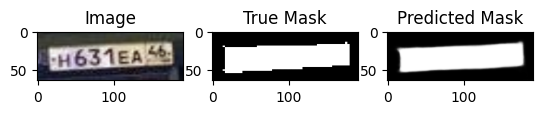

In [36]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    model_load.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model_load(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()
    
    if batch_idx == 0:
        break

In [37]:
predictions

tensor([[[[-3.4537, -5.3133, -5.9128,  ..., -5.7363, -4.9447, -3.3334],
          [-4.7225, -7.2694, -7.7044,  ..., -7.2041, -6.2488, -4.3299],
          [-5.0732, -7.5734, -8.3113,  ..., -7.5327, -6.5343, -4.8468],
          ...,
          [-5.6620, -8.4393, -9.0417,  ..., -8.0331, -7.1934, -5.5641],
          [-4.6667, -7.3363, -8.1403,  ..., -7.1861, -6.3059, -5.0523],
          [-2.7578, -4.8078, -5.5016,  ..., -4.8997, -4.2918, -3.3919]]],


        [[[-3.4036, -5.2518, -5.7923,  ..., -6.2376, -5.6408, -3.7694],
          [-4.6843, -7.2017, -7.6122,  ..., -8.3105, -7.6462, -5.3064],
          [-5.0677, -7.6174, -8.3172,  ..., -8.7729, -8.2018, -6.0850],
          ...,
          [-5.6611, -8.4351, -8.6355,  ..., -7.3582, -6.4783, -5.0978],
          [-4.4976, -7.0752, -7.5796,  ..., -6.8129, -5.7917, -4.6477],
          [-2.6661, -4.5470, -5.1361,  ..., -4.8792, -4.0631, -3.2267]]],


        [[[-3.4497, -5.4662, -6.1064,  ..., -6.6903, -5.6109, -3.7167],
          [-4.8044, -7.466

# prespectiv image

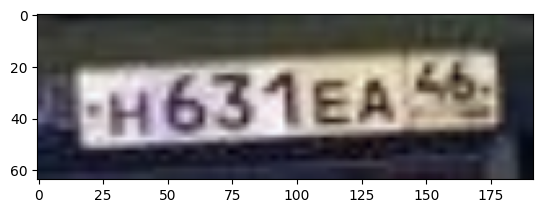

In [38]:
plt.imshow(image);

In [39]:
def convert_to_rgb(image):
    image = image.unsqueeze(2)
    rgb_image = torch.cat([image, image, image], dim=2)
    return rgb_image

In [40]:
predictions = model_load(images.to(device))
convert_to_rgb(torch.sigmoid(predictions[0])).size()

torch.Size([1, 64, 3, 192])

In [41]:
def perspective_transform_rgb(image_rgb, contours):
    # Проверяем, что есть хотя бы один контур
    if len(contours) == 0:
        return image_rgb
    
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    # Ensure that box points are in the correct order (top-left, top-right, bottom-right, bottom-left)
    rect = np.zeros((4, 2), dtype="float32")
    s = box.sum(axis=1)
    rect[0] = box[np.argmin(s)]
    rect[2] = box[np.argmax(s)]
    diff = np.diff(box, axis=1)
    rect[1] = box[np.argmin(diff)]
    rect[3] = box[np.argmax(diff)]
    
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    transformed_image = cv2.warpPerspective(image_rgb, M, (maxWidth, maxHeight))
    transformed_image_resized = cv2.resize(transformed_image, (512, 112))
    
    return transformed_image_resized

In [42]:
# plt.imshow(torch.sigmoid(predictions).cpu().permute(0, 2, 3, 1)[0]

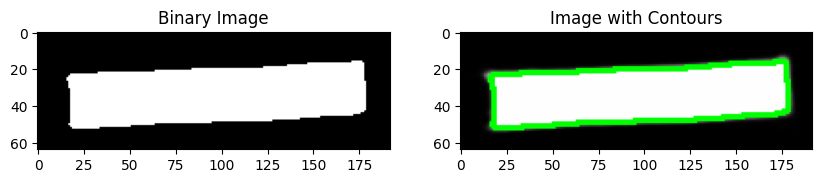

In [43]:
# Пример одноканального изображения
pred_mask_gray = torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0).detach().numpy()

# Преобразование в формат uint8 и нормализация
pred_mask_gray = (pred_mask_gray * 255).astype(np.uint8)

# Бинаризация изображения
_, binary_mask = cv2.threshold(pred_mask_gray, 200, 255, cv2.THRESH_BINARY)

# Находим контуры на бинаризованном изображении
contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Создаем копию изображения для рисования контуров
image_with_contours = cv2.cvtColor(pred_mask_gray, cv2.COLOR_GRAY2RGB)

# Рисуем контуры на изображении
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

# Преобразование в трехканальное RGB изображение
pred_mask_rgb = cv2.merge([binary_mask] * 3)

# Отображаем изображение с контурами с помощью matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Image")

plt.subplot(1, 2, 2)
plt.imshow(image_with_contours)
plt.title("Image with Contours")

plt.show()

In [44]:
pred_mask_rgb.shape

(64, 192, 3)

(16, 16) (179, 53) (163, 37)


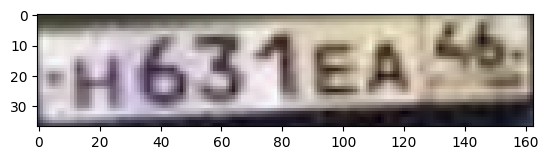

In [45]:
(x, y, w, h) = cv2.boundingRect(contours[0])
cv2.rectangle(pred_mask_rgb, (x, y), (x + w, y + h), (255, 255, 0), thickness=2)

print((x, y), (w + x, h + y), (w, h))
plt.imshow(image[y:h + y, x:w + x])

/tmp/ipykernel_24/865184434.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


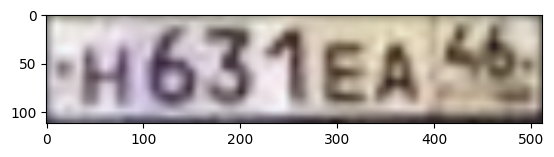

In [46]:
plt.imshow(perspective_transform_rgb(image, contours));

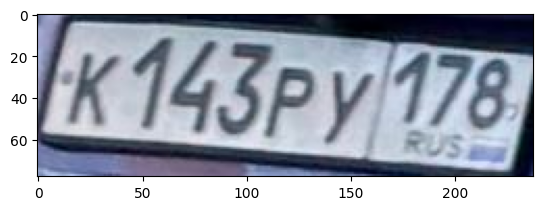

In [47]:
plt.imshow(cv2.imread('/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/c423c7ca94a54046_jpg.rf.053c3be3058f28f0b2fb8ca4db0ed402.jpg'))

In [48]:
image = Image.open('/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/c0717dfc226b4d29_jpg.rf.8e6a9dc398e45b5b0d9b1cd1fcef1fcf.jpg').convert('RGB')
image = image_transform(image)

In [49]:
model(image.to(device).unsqueeze(0))

tensor([[[[-3.2567, -4.9657, -5.3371,  ..., -5.1799, -4.2963, -2.9148],
          [-4.6026, -6.9819, -7.2570,  ..., -6.8462, -5.7764, -4.0106],
          [-4.9874, -7.4429, -8.0079,  ..., -7.3665, -6.1592, -4.5711],
          ...,
          [-5.1469, -7.8510, -8.7543,  ..., -7.8085, -7.0088, -5.5613],
          [-4.1855, -6.8397, -7.7823,  ..., -7.3190, -6.3212, -5.1429],
          [-2.4882, -4.4615, -5.2662,  ..., -5.1669, -4.4669, -3.5202]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [50]:
# class SegmentCarNumber:
#     def __init__(self, unet_path: str, encoder_path: str) -> None:
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

#         self.model = smp.Unet(
#             encoder_name='resnet34',
#             encoder_weights=None,
#             classes=1,
#             activation=None,
#         )

#         encoder_state_dict = torch.load(encoder_path, map_location=torch.device(self.device))
#         self.model.encoder.load_state_dict(encoder_state_dict)

#         checkpoint = torch.load(unet_path, map_location=torch.device(self.device))
#         self.model.load_state_dict(checkpoint['model_state_dict'])

#         self.model = self.model.to(self.device)

#         self.image_transform = transforms.Compose([
#             transforms.Resize((64, 192)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])
    
#     def predict(self, image: str | Image.Image, batch_size=None, shuffle=False, num_workers=2) -> np.ndarray:
#         self.model.eval()
#         if batch_size:
#             result_pred = []
#             data = pd.DataFrame({'image_path': [os.path.join(image, f) for f in os.listdir(image)]})
#             dataset = SegmentationDataset(dataframe=data, transform=self.image_transform)
#             data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
            
#             for indx, batch in enumerate(tqdm(data_loader)):
#                 images, _ = batch
#                 with torch.no_grad():
#                     prediction = self.model(images.to(self.device))
#                 result_pred.extend([i for i in 
#                     (torch.sigmoid(prediction).cpu().permute(0, 2, 3, 1).detach().numpy()* 255).astype(np.uint8)
#                     ])
#             return result_pred
#         else:
#             if isinstance(image, str):
#                 image = Image.open(image).convert('RGB')
#                 image = self.image_transform(image)
#             elif isinstance(image, Image.Image):
#                 image = self.image_transform(image)
#             with torch.no_grad():
#                 prediction = self.model(image.to(self.device).unsqueeze(0))
#             prediction = torch.sigmoid(prediction[0]).cpu().permute(1, 2, 0).detach().numpy()
#             prediction = (prediction * 255).astype(np.uint8)
#             return prediction
    
#     @staticmethod
#     def perspective_transform_rgb(image_rgb, mask_img) -> np.ndarray:
#         _, binary_mask = cv2.threshold(mask_img, 200, 255, cv2.THRESH_BINARY)
#         contours, _ = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours) == 0:
#             return image_rgb
        
#         largest_contour = max(contours, key=cv2.contourArea)
#         rect = cv2.minAreaRect(largest_contour)
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)
        
#         # Ensure that box points are in the correct order (top-left, top-right, bottom-right, bottom-left)
#         rect = np.zeros((4, 2), dtype="float32")
#         s = box.sum(axis=1)
#         rect[0] = box[np.argmin(s)]
#         rect[2] = box[np.argmax(s)]
#         diff = np.diff(box, axis=1)
#         rect[1] = box[np.argmin(diff)]
#         rect[3] = box[np.argmax(diff)]
        
#         (tl, tr, br, bl) = rect
#         widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
#         widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
#         maxWidth = max(int(widthA), int(widthB))
        
#         heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
#         heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
#         maxHeight = max(int(heightA), int(heightB))
        
#         dst = np.array([
#             [0, 0],
#             [maxWidth - 1, 0],
#             [maxWidth - 1, maxHeight - 1],
#             [0, maxHeight - 1]], dtype="float32")
        
#         M = cv2.getPerspectiveTransform(rect, dst)
#         transformed_image = cv2.warpPerspective(image_rgb, M, (maxWidth, maxHeight))
#         transformed_image_resized = cv2.resize(transformed_image, (512, 112))
        
#         return transformed_image_resized

In [51]:
# model_num = SegmentCarNumber(encoder_path="/kaggle/working/encoder_weights.pth", unet_path="/kaggle/working/unet_model.pth")

In [52]:
# plt.imshow(model_num.perspective_transform_rgb(cv2.imread(
#     '/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/c423c7ca94a54046_jpg.rf.053c3be3058f28f0b2fb8ca4db0ed402.jpg'
# ),
#     model_num.predict(
#         image='/kaggle/input/car-number-segment/car_numbers.v1i.coco-segmentation/train/c423c7ca94a54046_jpg.rf.053c3be3058f28f0b2fb8ca4db0ed402.jpg')))